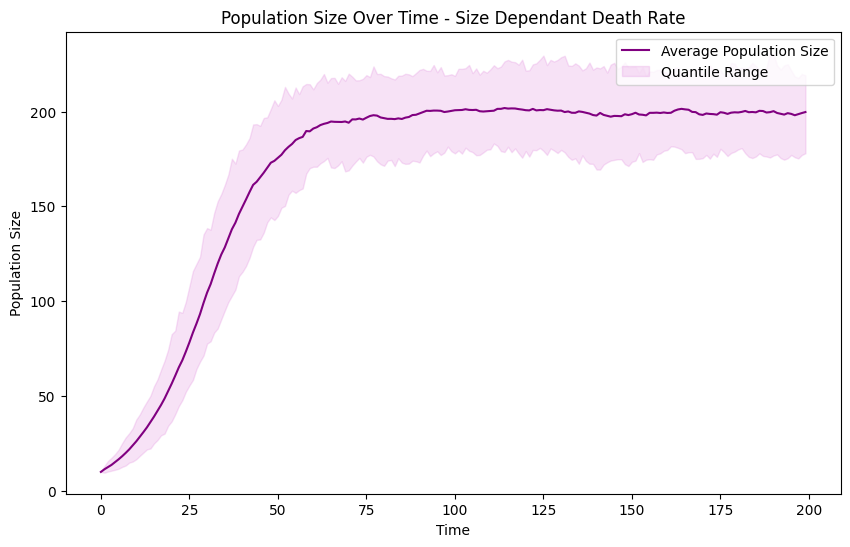

0.0

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters for the logistic model with size dependent death rate
def set_parameters_with_size_dependent_death_rate(initial_population, birth_rate, base_death_rate, carrying_capacity):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'base_death_rate': base_death_rate,
        'carrying_capacity': carrying_capacity
    }

# Gillespie algorithm for size dependent death rate
def gillespie_simulation(params, max_time=100):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    base_death_rate = params['base_death_rate']
    carrying_capacity = params['carrying_capacity']
    
    time_points = [0]
    population_sizes = [population]
    
    while time_points[-1] < max_time and population > 0:
        birth_propensity = birth_rate * population
        death_propensity = base_death_rate * (population / carrying_capacity) * population
        total_propensity = birth_propensity + death_propensity
        
        if total_propensity == 0:
            break
        
        time_to_next_event = np.random.exponential(1 / total_propensity)
        time_points.append(time_points[-1] + time_to_next_event)
        
        if np.random.rand() < birth_propensity / total_propensity:
            population += 1
        else:
            population -= 1
        
        population_sizes.append(population)
        
    return time_points, population_sizes

# Run multiple simulations
def run_multiple_simulations_with_size_dependent_death_rate(params, num_simulations):
    all_time_points = []
    all_population_sizes = []
    
    for _ in range(num_simulations):
        time_points, population_sizes = gillespie_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
    
    # Align population sizes for quantile calculation
    max_time = max([max(t) for t in all_time_points])
    aligned_population_sizes = np.zeros((num_simulations, len(np.linspace(0, max_time, 200))))
    
    for i, population_sizes in enumerate(all_population_sizes):
        aligned_population_sizes[i, :len(population_sizes)] = np.interp(np.linspace(0, max_time, 200), all_time_points[i], population_sizes)
    
    average_population_sizes = np.mean(aligned_population_sizes, axis=0)
    lower_quantile = np.percentile(aligned_population_sizes, 5, axis=0)
    upper_quantile = np.percentile(aligned_population_sizes, 95, axis=0)
    extinction_probability = np.mean(aligned_population_sizes[:, -1] == 0)
    
    return aligned_population_sizes, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

# Parameters for the logistic model with size dependent death rate
params = set_parameters_with_size_dependent_death_rate(
    initial_population=10, 
    birth_rate=0.2, 
    base_death_rate=0.1, 
    carrying_capacity=100
)

num_simulations = 100
aligned_population_sizes, average_population_sizes, lower_quantile, upper_quantile, extinction_probability = run_multiple_simulations_with_size_dependent_death_rate(params, num_simulations)

# Plotting results
def plot_multiple_simulations_with_quantiles(avg_population_sizes, lower_quantile, upper_quantile):
    plt.figure(figsize=(10, 6))
    plt.plot(avg_population_sizes, color='purple', label='Average Population Size')
    plt.fill_between(range(len(avg_population_sizes)), lower_quantile, upper_quantile, color='orchid', alpha=0.2, label='Quantile Range')
    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Population Size Over Time - Size Dependant Death Rate')
    plt.legend()
    plt.show()

plot_multiple_simulations_with_quantiles(average_population_sizes, lower_quantile, upper_quantile)

extinction_probability


In [ ]:
# model with fixed birth and death rates

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def set_parameters(initial_population=50, birth_rate=0.1, death_rate=0.1, competition_coefficient=0.01, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    max_time = params['max_time']
    carrying_capacity = params['carrying_capacity']
    
    time_points = [0]
    population_sizes = [population]
    
    while population > 0 and time_points[-1] < max_time:
        effective_birth_rate = params['birth_rate'] * (1 - population / carrying_capacity) + params['death_rate']*(population/carrying_capacity)
        next_event_time = np.random.exponential(1 / (death_rate*population + effective_birth_rate*population))
        
        
        # if birth_event_time < death_event_time:
        if np.random.rand() < effective_birth_rate / (effective_birth_rate + death_rate):
            population += 1
        else:
            population -= 1
        
        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)
    
    return time_points, population_sizes


In [ ]:

def run_multiple_simulations_with_quantiles(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']
    
    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1
    
    # Calculate quantiles
    max_len = max(len(sim) for sim in all_population_sizes)
    num_points = 1000  # Number of points for interpolation
    average_time_points = np.linspace(0, max_time, num_points)
    interpolated_populations = np.zeros((num_simulations, num_points))
    for i in range(num_simulations):
        interpolated_populations[i] = np.interp(average_time_points, all_time_points[i], all_population_sizes[i])
    average_population_sizes = np.mean(interpolated_populations, axis=0)
    lower_quantile = np.nanquantile(interpolated_populations, 0.05, axis=0)
    upper_quantile = np.nanquantile(interpolated_populations, 0.95, axis=0)
    
    extinction_probability = extinction_count / num_simulations
    
    return average_time_points, interpolated_populations, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

def plot_multiple_simulations_with_quantiles(average_time_points, interpolated_populations, average_population_sizes, lower_quantile, upper_quantile):
    plt.figure(figsize=(10, 6))

    plt.plot(average_time_points, average_population_sizes, color='purple', linestyle='-', label='Average Population Size')
    plt.fill_between(average_time_points, lower_quantile, upper_quantile, color='orchid', alpha=0.5, label='Quantile Range')
    
    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Population Size over Time')
    plt.legend()
    plt.show()



In [ ]:
# Example usage
params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1)

# Multiple simulations\
num_simulations = 100
all_time_points, all_population_sizes, average_population_sizes, lower_quantile, upper_quantile, extinction_probability = run_multiple_simulations_with_quantiles(params, num_simulations)

# Plot results
plot_multiple_simulations_with_quantiles(all_time_points, all_population_sizes, average_population_sizes, lower_quantile, upper_quantile)

# Print extinction probability
print(f"Extinction Probability: {extinction_probability:.2f}")